# Binary Classification with a Bank Dataset
In this notebook, we will be predicting the binary classification of the bank dataset. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/playground-series-s5e8).

<div align="center">
<img src="https://www.kaggle.com/competitions/91719/images/header" />
</div>

## 1. Importing Libraries

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.utils import resample
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings

### Configurations

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [3]:
df = pd.read_csv('train.csv', index_col='id')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [5]:
df.shape

(750000, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

## 3. Exploratory Data Analysis

In [9]:
# Copy of the original dataset
dfo = df.copy()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
day,750000.0,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0
y,750000.0,0.120651,0.325721,0.0,0.0,0.0,0.0,1.0


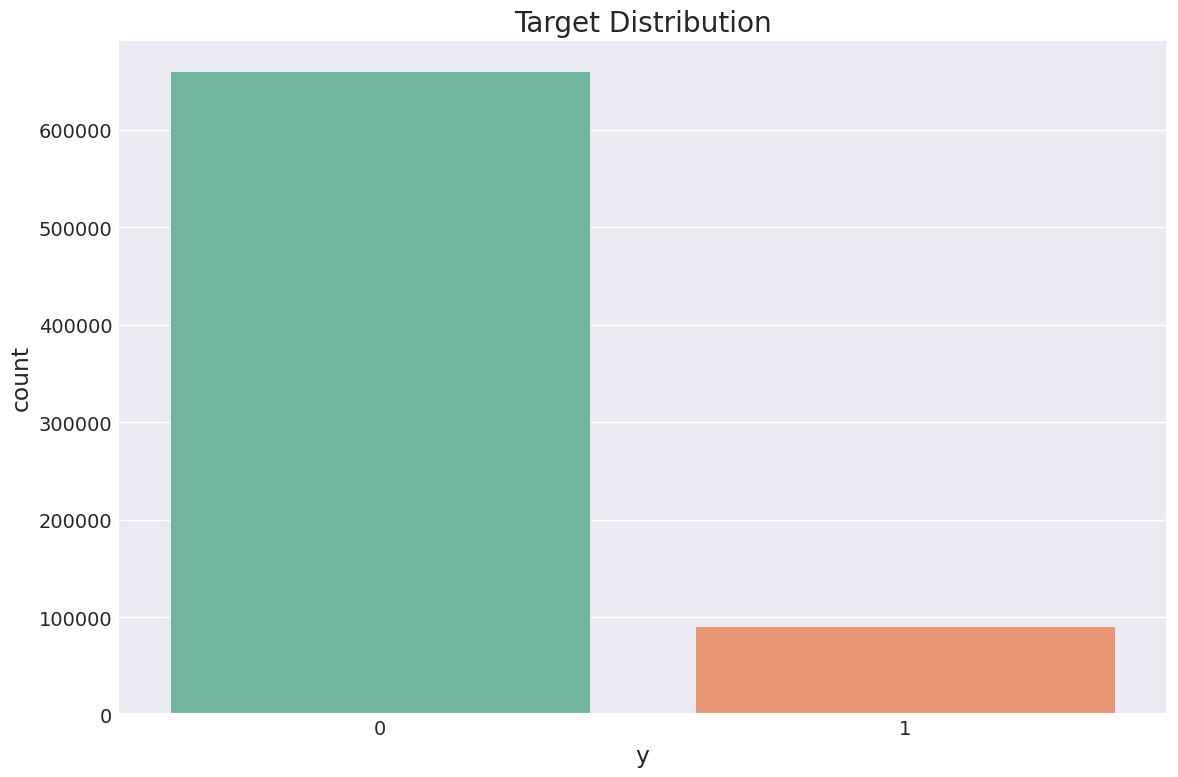

In [11]:
sns.countplot(
    df,
    x='y',
    palette='Set2'
)
plt.title('Target Distribution')
plt.tight_layout()

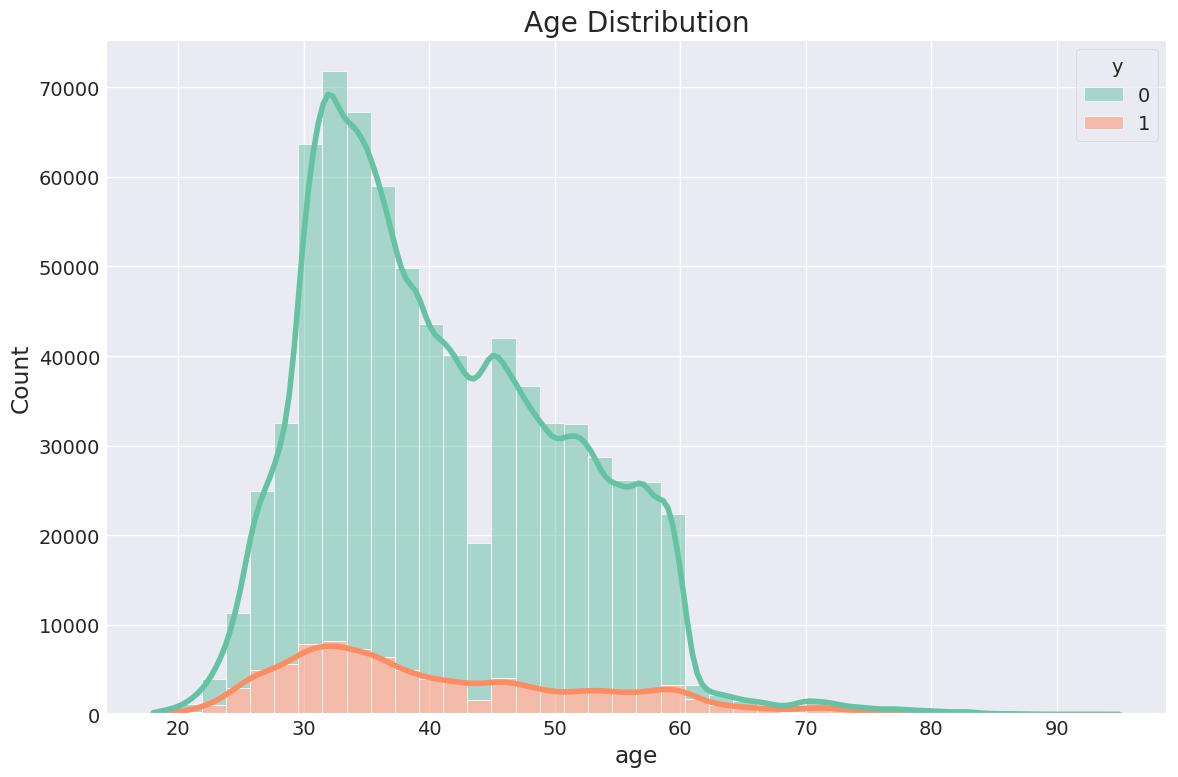

In [12]:
sns.histplot(
    data=df,
    x='age',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2'
)
plt.title('Age Distribution')
plt.tight_layout()

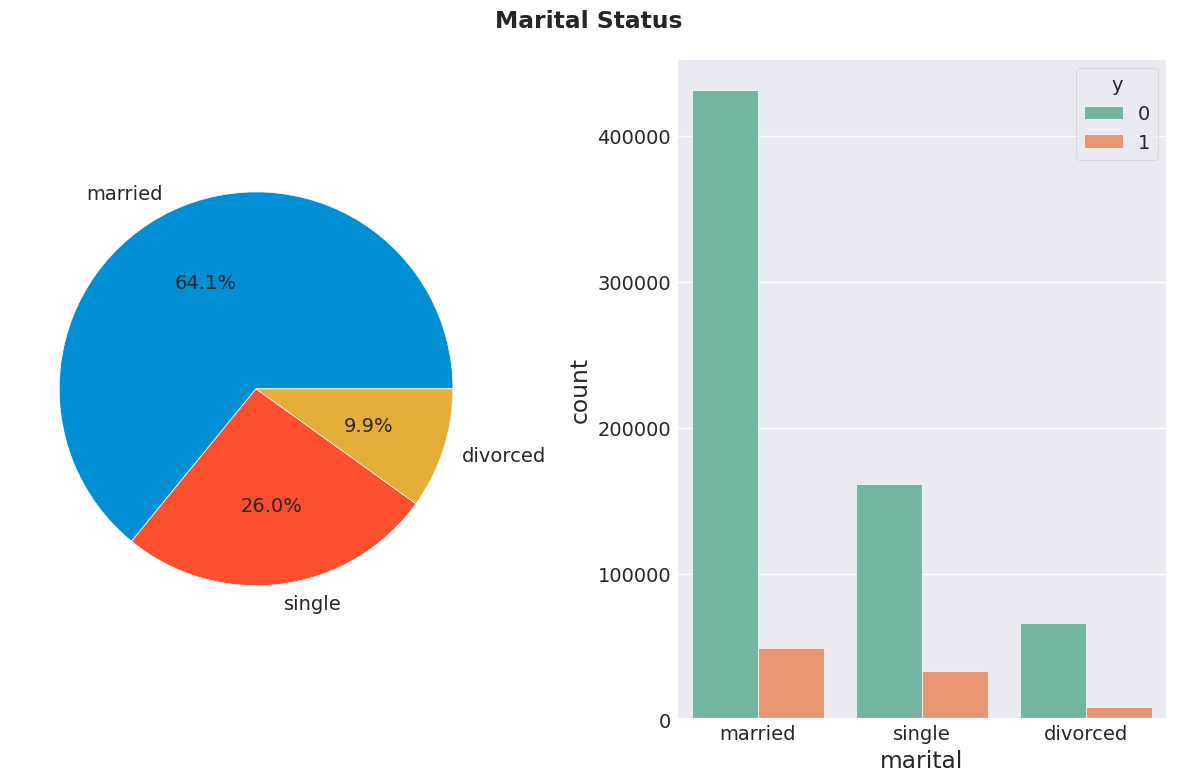

In [13]:
plt.subplot(121)
df['marital'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='marital',
    hue='y',
    palette='Set2'
)

plt.suptitle('Marital Status', fontweight='bold')
plt.tight_layout()

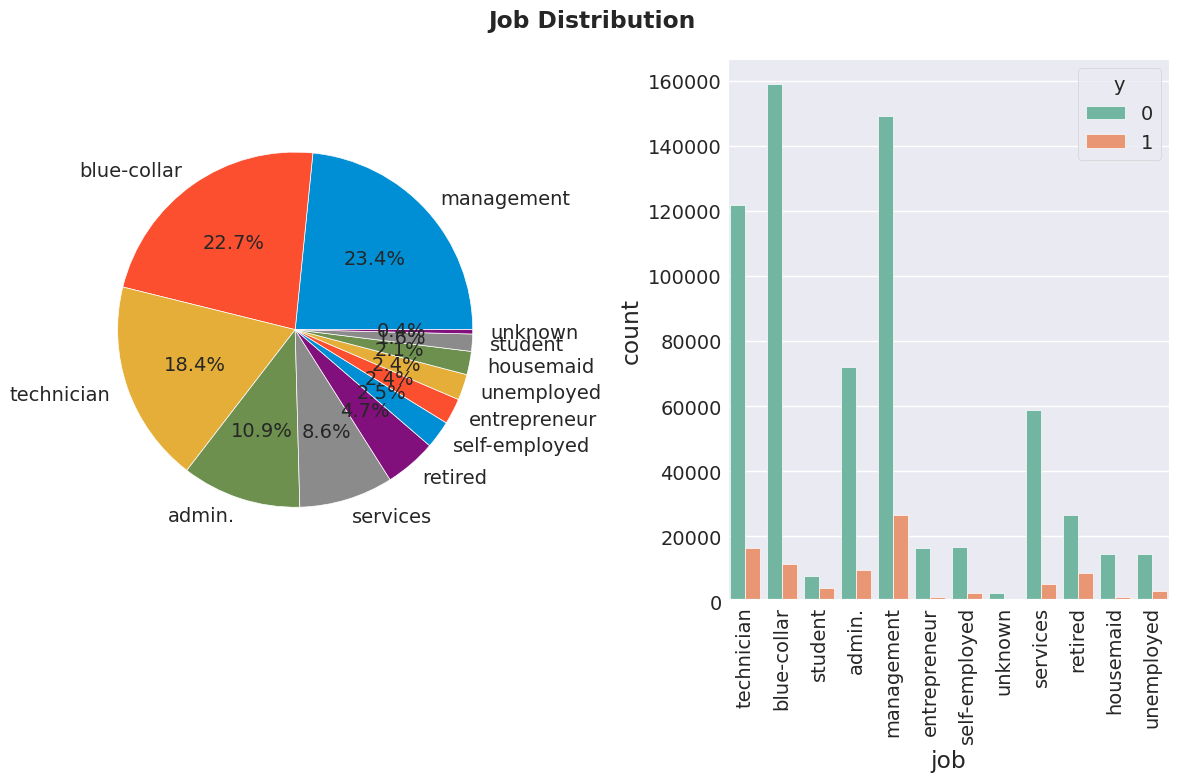

In [14]:
plt.subplot(121)
df['job'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='job',
    hue='y',
    palette='Set2'
)
plt.xticks(rotation=90)

plt.suptitle('Job Distribution', fontweight='bold')
plt.tight_layout()

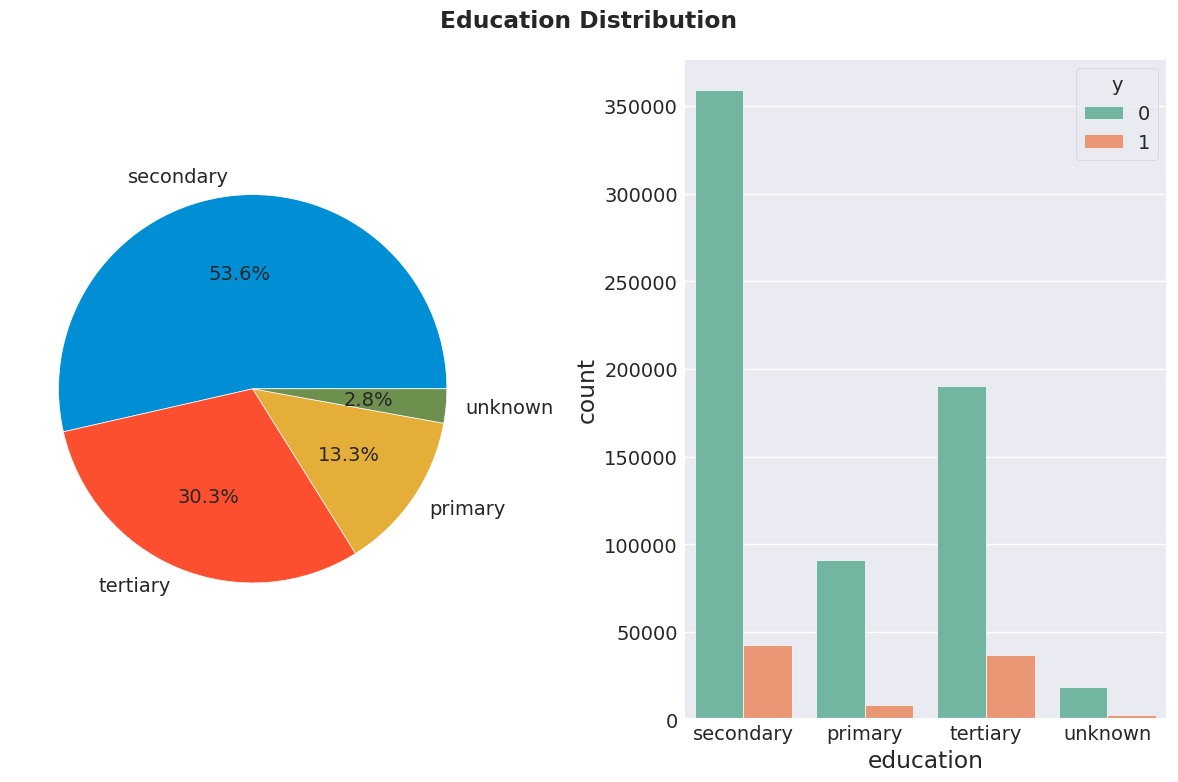

In [15]:
plt.subplot(121)
df['education'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='education',
    hue='y',
    palette='Set2'
)

plt.suptitle('Education Distribution', fontweight='bold')
plt.tight_layout()

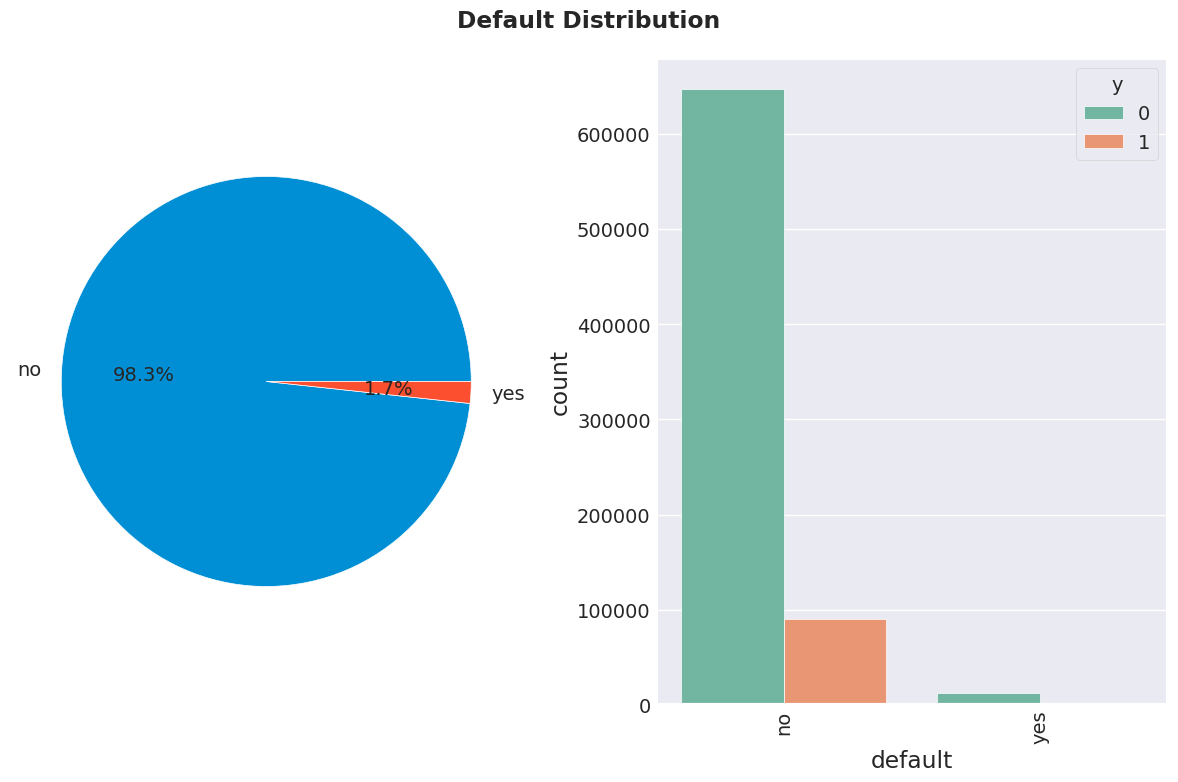

In [16]:
plt.subplot(121)
df['default'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='default',
    hue='y',
    palette='Set2'
)
plt.xticks(rotation=90)

plt.suptitle('Default Distribution', fontweight='bold')
plt.tight_layout()

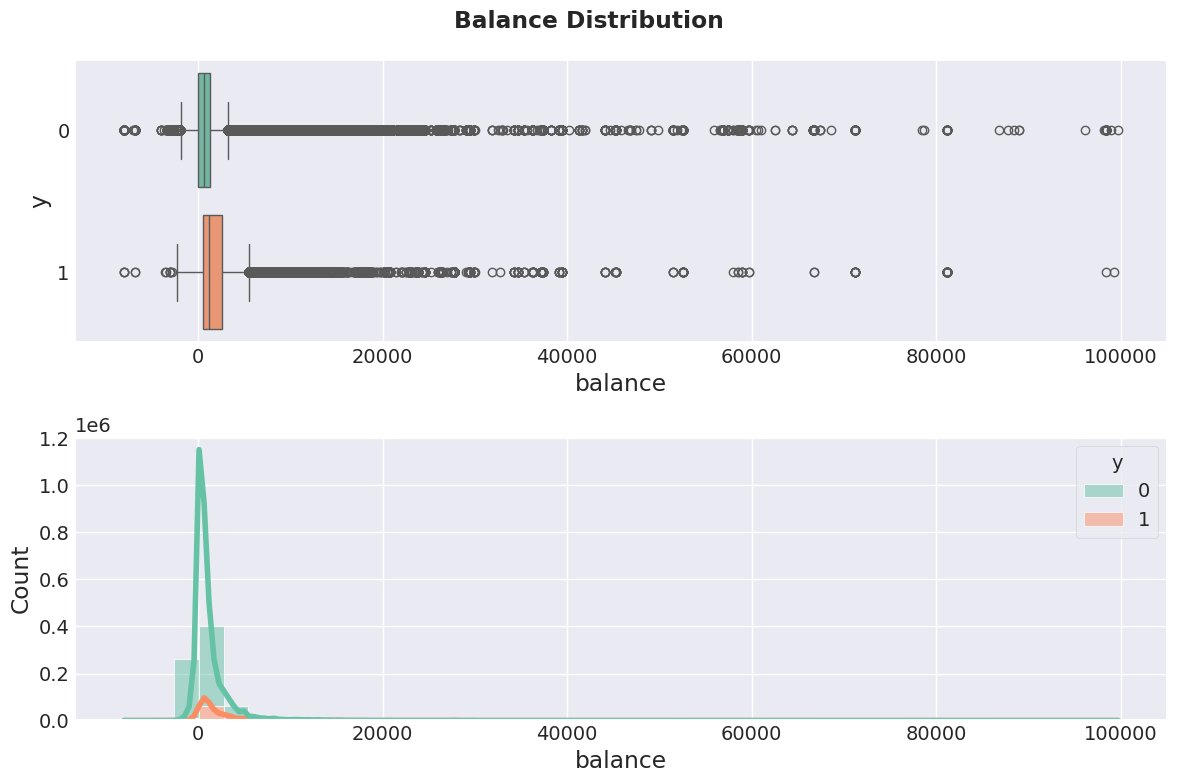

In [17]:
plt.subplot(211)
sns.boxplot(
    df,
    x='balance',
    y='y',
    orient='h',
    palette='Set2'
)

plt.subplot(212)
sns.histplot(
    df,
    x='balance',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2'
)

plt.suptitle('Balance Distribution', fontweight='bold')
plt.tight_layout()

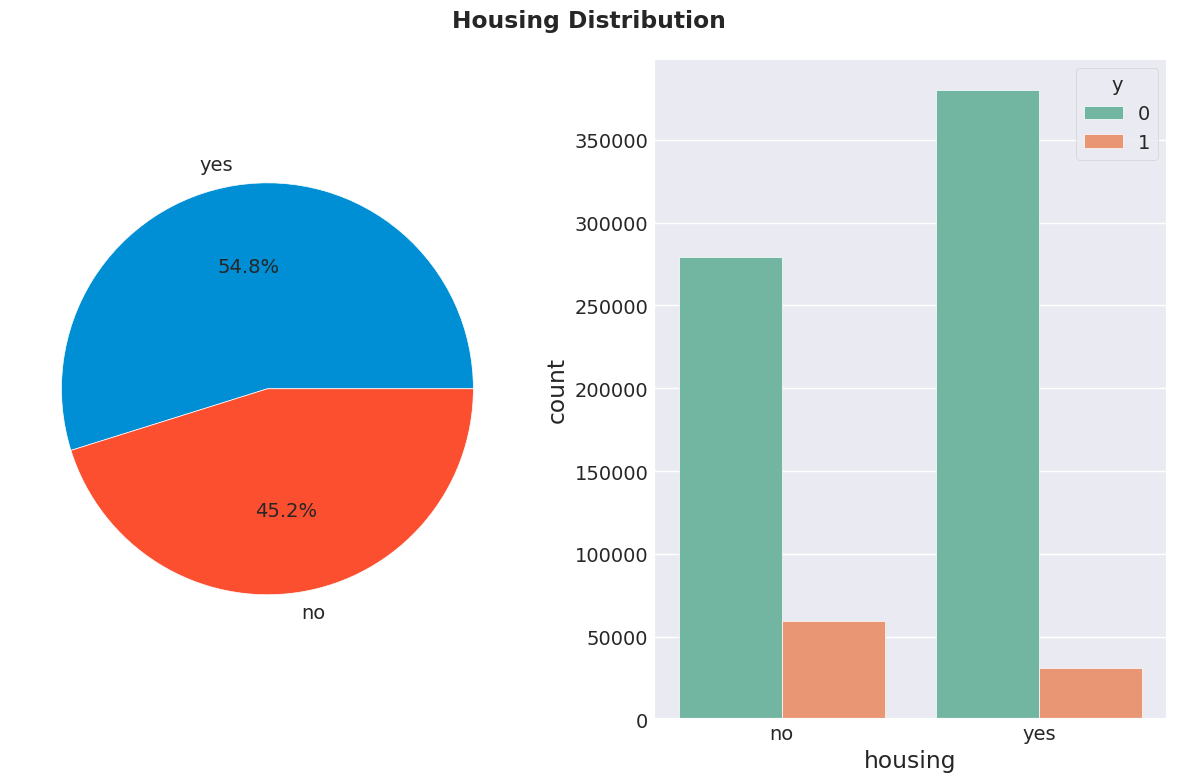

In [18]:
plt.subplot(121)
df['housing'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='housing',
    hue='y',
    palette='Set2'
)

plt.suptitle('Housing Distribution', fontweight='bold')
plt.tight_layout()

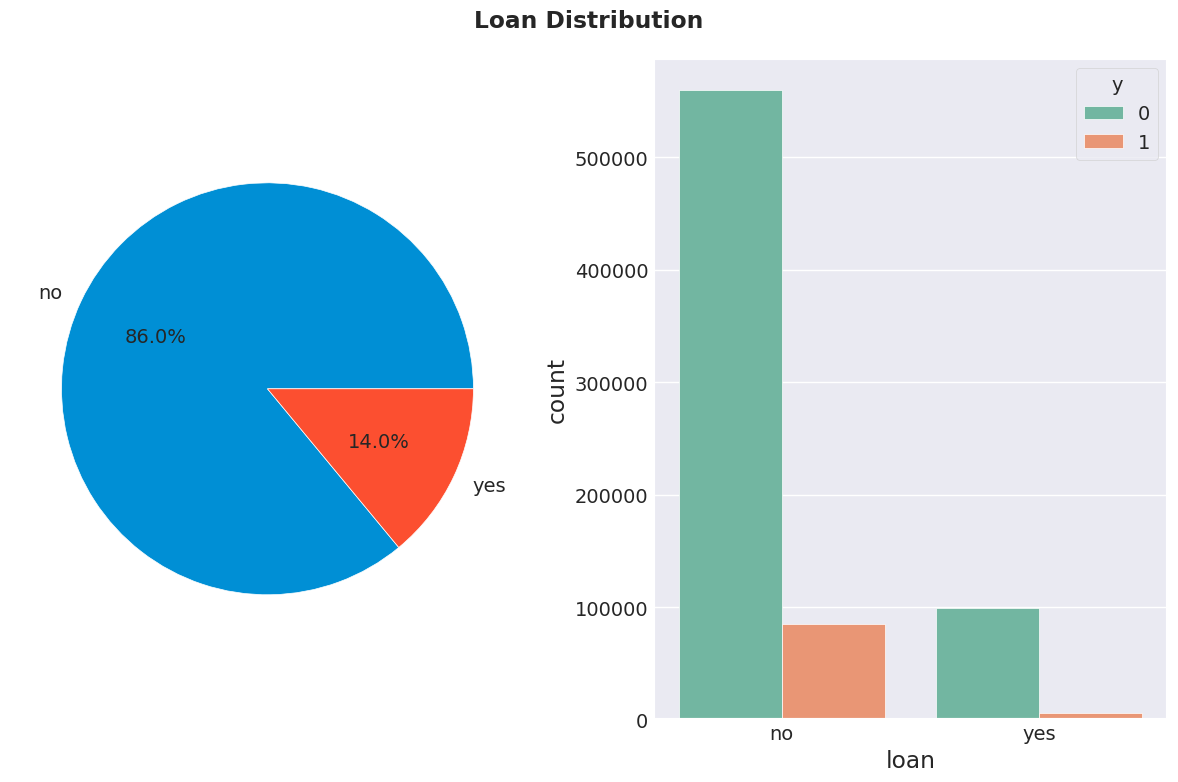

In [19]:
plt.subplot(121)
df['loan'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='loan',
    hue='y',
    palette='Set2'
)

plt.suptitle('Loan Distribution', fontweight='bold')
plt.tight_layout()

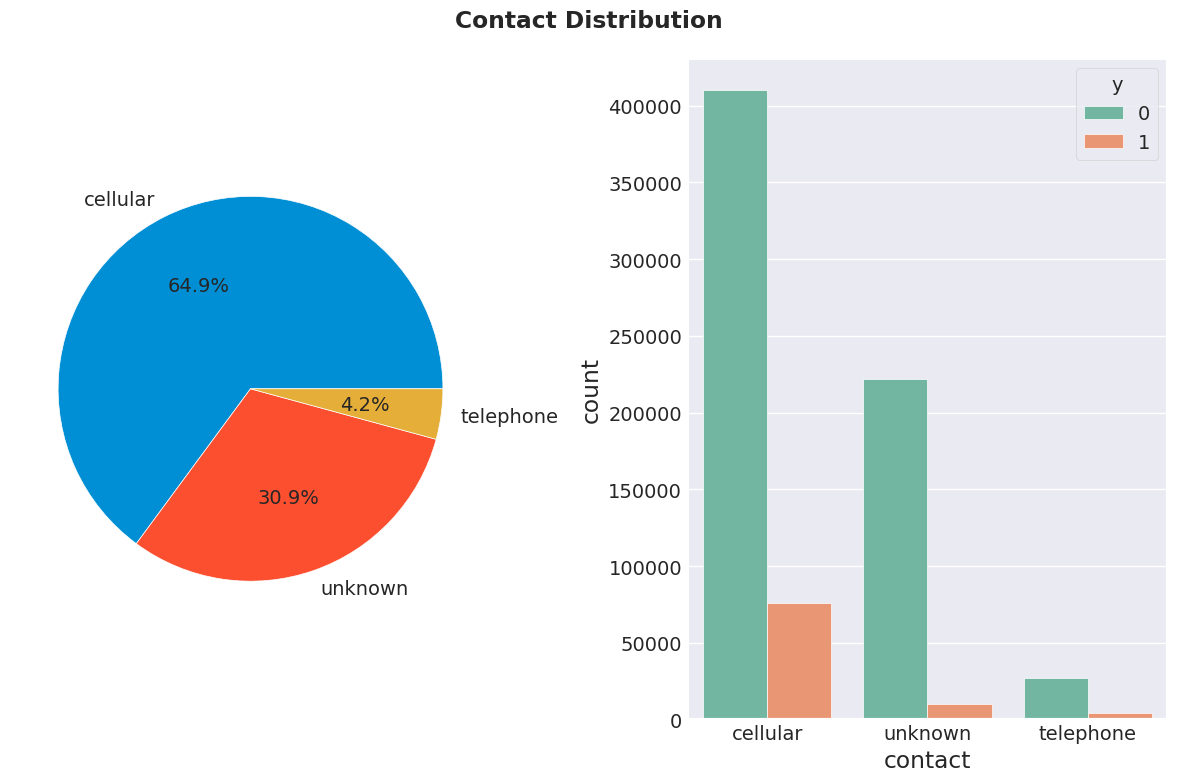

In [20]:
plt.subplot(121)
df['contact'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='contact',
    hue='y',
    palette='Set2'
)

plt.suptitle('Contact Distribution', fontweight='bold')
plt.tight_layout()

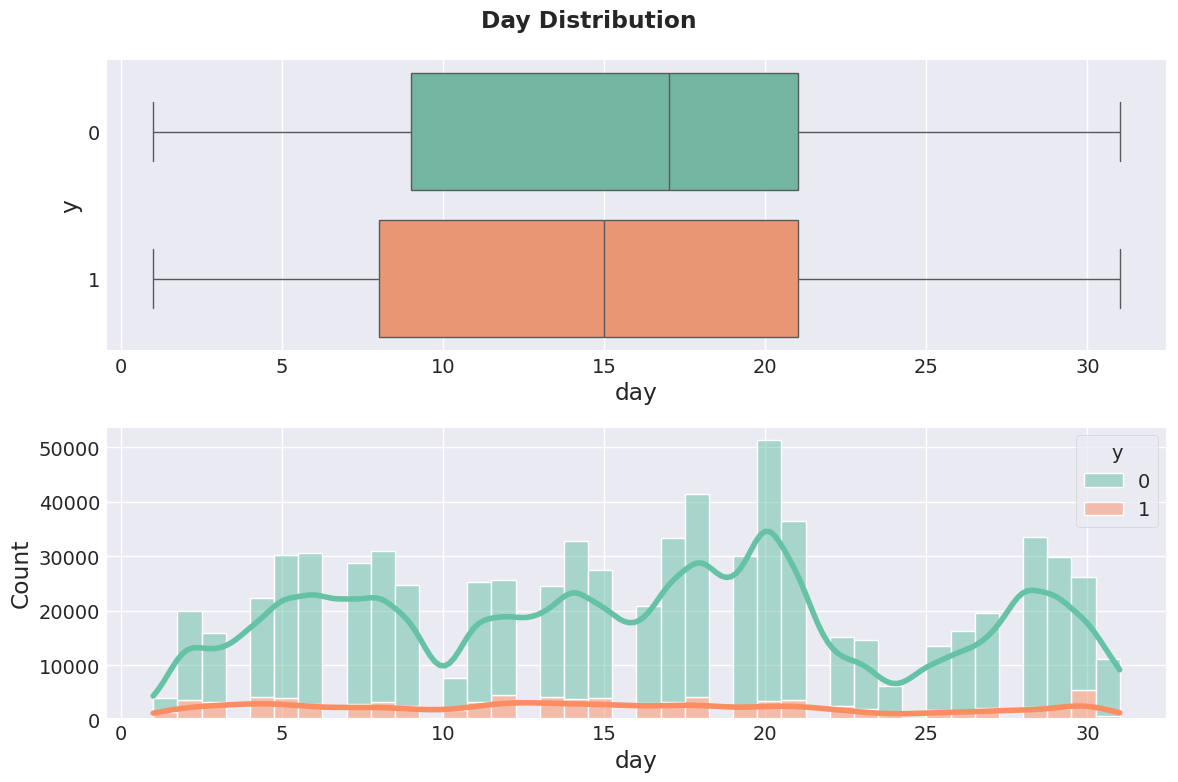

In [21]:
plt.subplot(211)
sns.boxplot(
    df,
    x='day',
    y='y',
    orient='h',
    palette='Set2'
)

plt.subplot(212)
sns.histplot(
    df,
    x='day',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2',
    linewidth=1
)

plt.suptitle('Day Distribution', fontweight='bold')
plt.tight_layout()

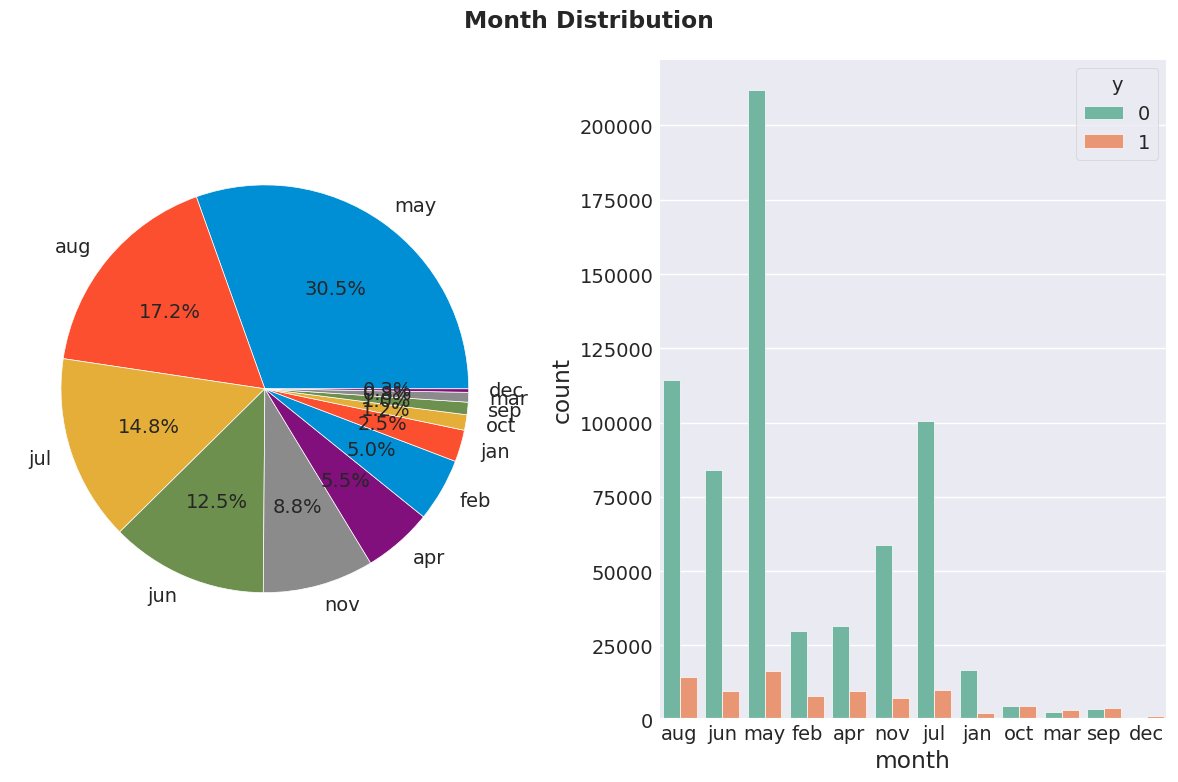

In [22]:
plt.subplot(121)
df['month'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='month',
    hue='y',
    palette='Set2'
)

plt.suptitle('Month Distribution', fontweight='bold')
plt.tight_layout()

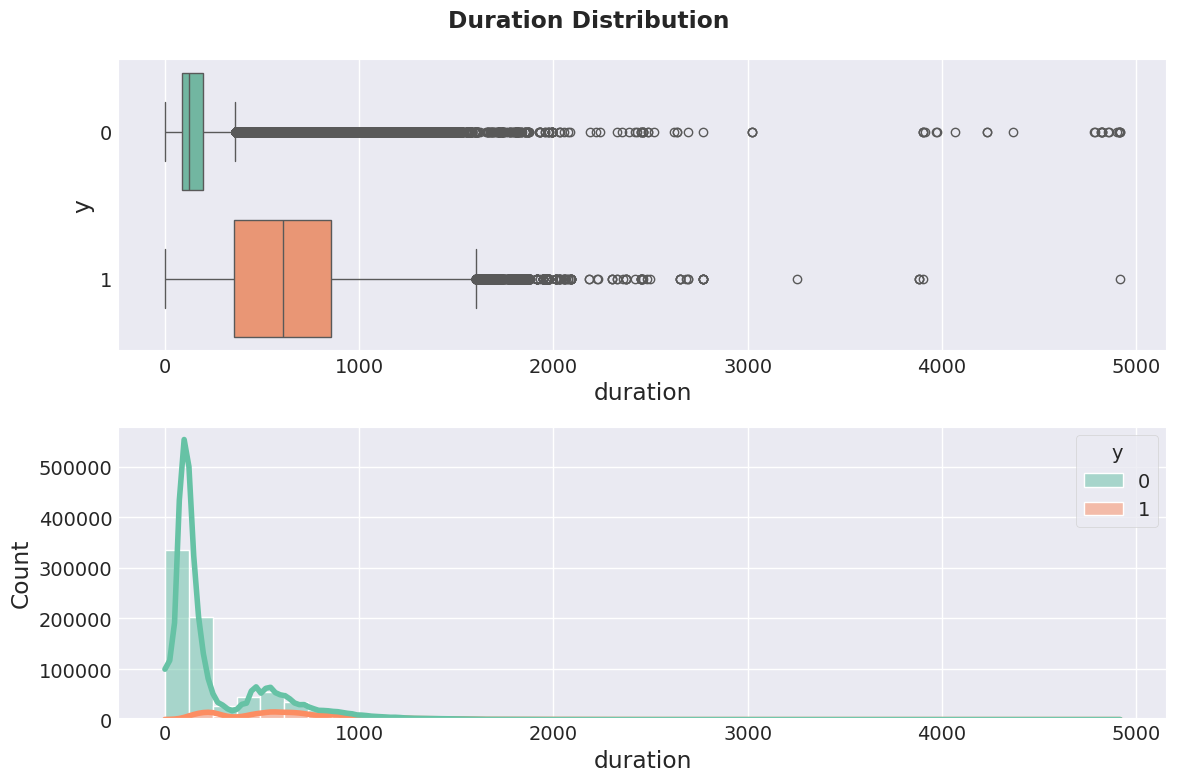

In [23]:
plt.subplot(211)
sns.boxplot(
    df,
    x='duration',
    y='y',
    orient='h',
    palette='Set2'
)

plt.subplot(212)
sns.histplot(
    df,
    x='duration',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2',
    linewidth=1
)

plt.suptitle('Duration Distribution', fontweight='bold')
plt.tight_layout()

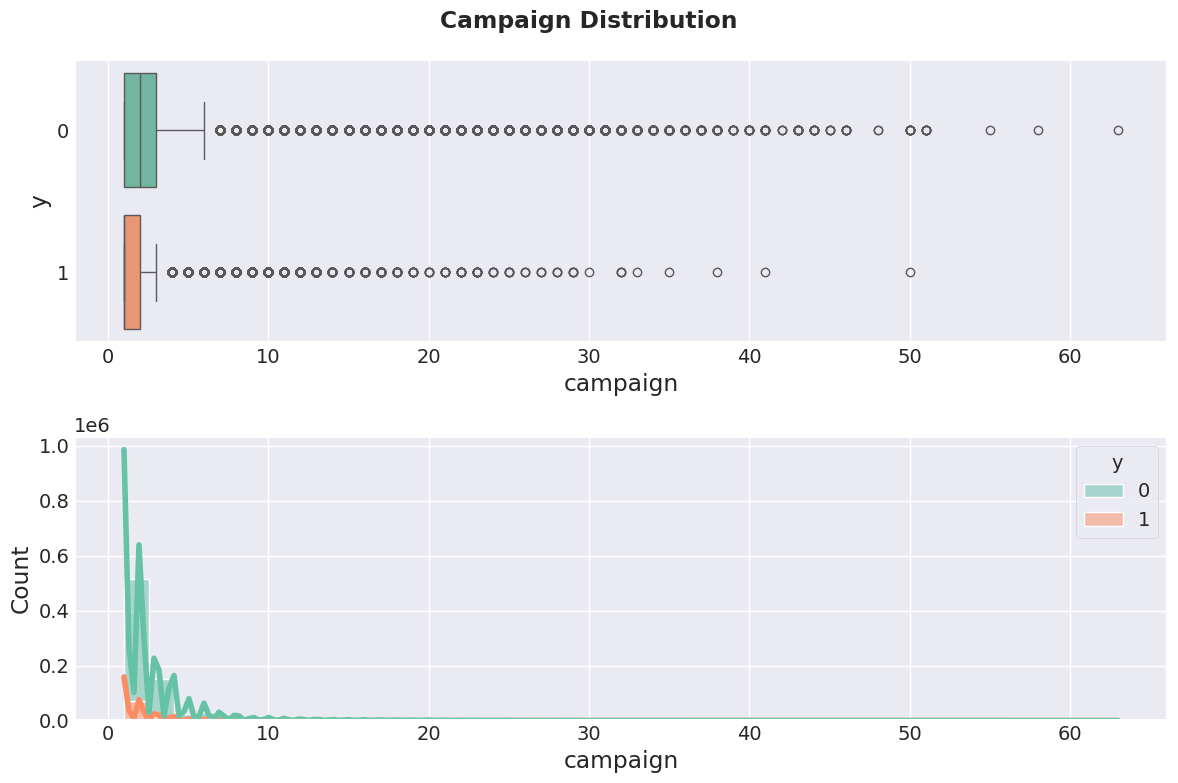

In [24]:
plt.subplot(211)
sns.boxplot(
    df,
    x='campaign',
    y='y',
    orient='h',
    palette='Set2'
)

plt.subplot(212)
sns.histplot(
    df,
    x='campaign',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2',
    linewidth=1
)

plt.suptitle('Campaign Distribution', fontweight='bold')
plt.tight_layout()

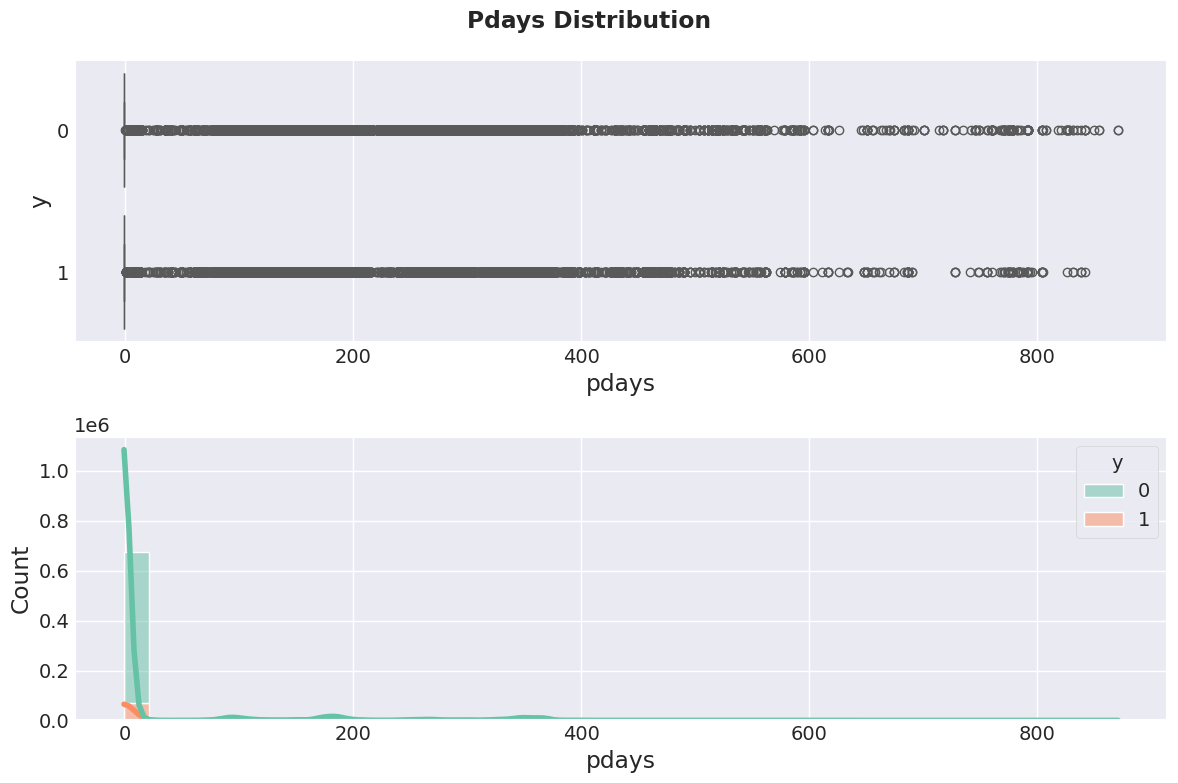

In [25]:
plt.subplot(211)
sns.boxplot(
    df,
    x='pdays',
    y='y',
    orient='h',
    palette='Set2'
)

plt.subplot(212)
sns.histplot(
    df,
    x='pdays',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2',
    linewidth=1
)

plt.suptitle('Pdays Distribution', fontweight='bold')
plt.tight_layout()

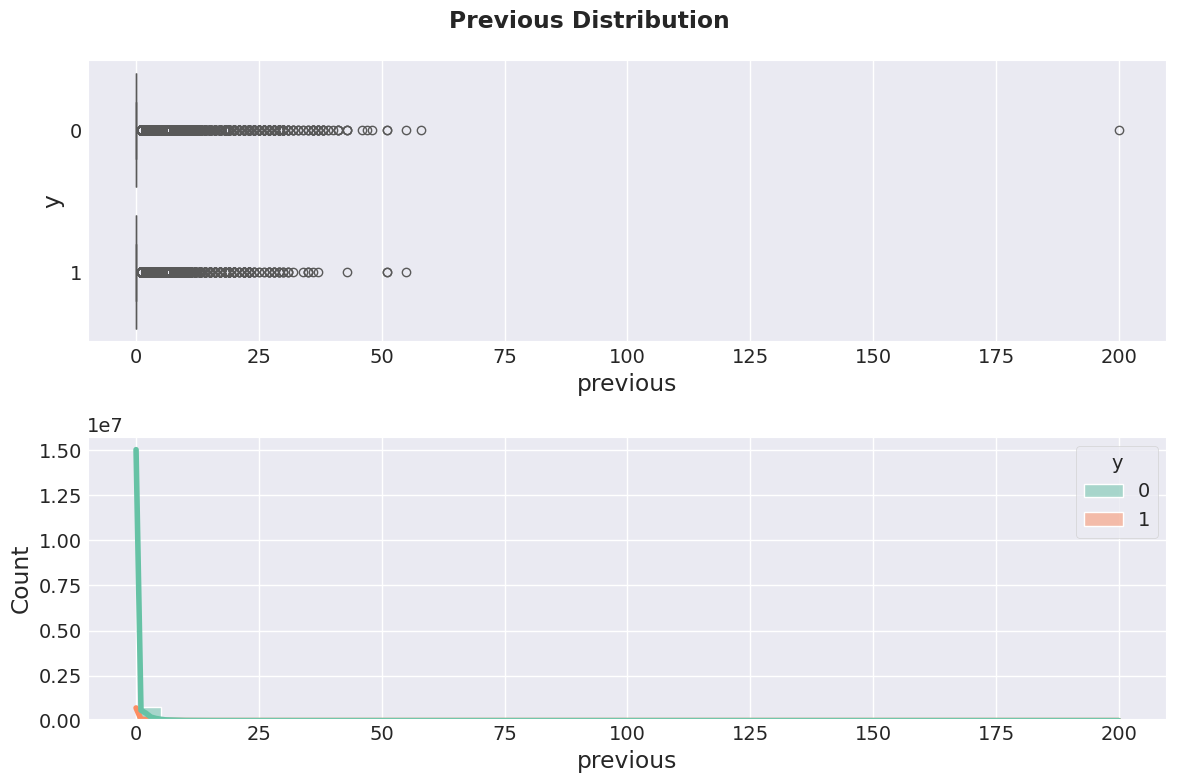

In [26]:
plt.subplot(211)
sns.boxplot(
    df,
    x='previous',
    y='y',
    orient='h',
    palette='Set2'
)

plt.subplot(212)
sns.histplot(
    df,
    x='previous',
    bins=40,
    kde=True,
    hue='y',
    multiple='stack',
    palette='Set2',
    linewidth=1
)

plt.suptitle('Previous Distribution', fontweight='bold')
plt.tight_layout()

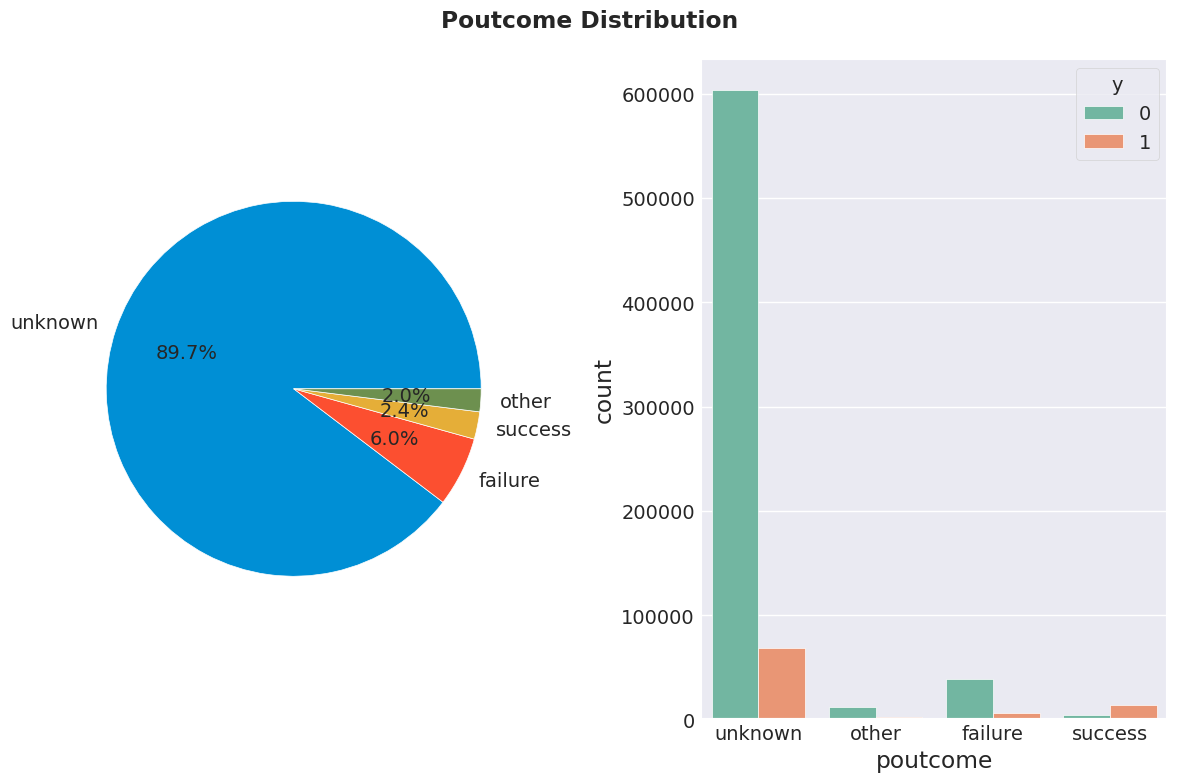

In [27]:
plt.subplot(121)
df['poutcome'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')

plt.subplot(122)
sns.countplot(
    df,
    x='poutcome',
    hue='y',
    palette='Set2'
)

plt.suptitle('Poutcome Distribution', fontweight='bold')
plt.tight_layout()

In [28]:
l = ['default', 'housing', 'loan']
for i in l:
    df[i] = df[i].map({'no': 0, 'yes': 1})
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,0,7,0,0,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,0,514,0,0,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,0,602,1,0,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,0,34,1,0,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,0,889,1,0,cellular,3,feb,902,1,-1,0,unknown,1


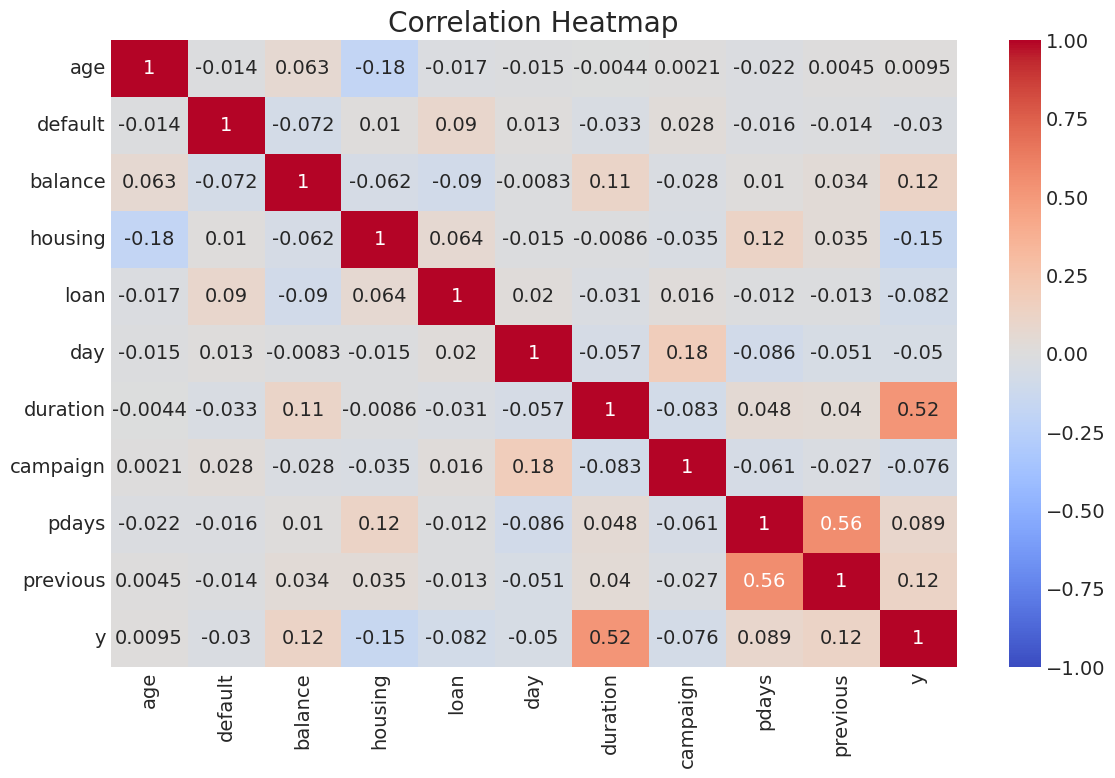

In [29]:
sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0
)
plt.title('Correlation Heatmap')
plt.tight_layout()

In [30]:
abs(df.corr(numeric_only=True)['y']).sort_values(ascending=False)

y           1.000000
duration    0.519283
housing     0.153589
balance     0.122513
previous    0.119552
pdays       0.089277
loan        0.081639
campaign    0.075829
day         0.049625
default     0.030134
age         0.009523
Name: y, dtype: float64

## 4. Data Preprocessing

In [31]:
df.y.value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

In [32]:
# Downsampling the dataset to balance the classes
df_majority = df[df['y'] == 0]
df_minority = df[df['y'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.shape

(180976, 17)

In [33]:
df = df_downsampled

In [34]:
x = df.drop(columns=['y', 'previous', 'pdays', 'loan', 'campaign', 'day', 'default', 'age'])
y = df['y']

In [35]:
x_dummies = pd.get_dummies(x)

In [36]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_dummies)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## 5. Model Training

In [38]:
models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'XGBClassifier': xgb.XGBClassifier(),
    'LightGBMClassifier': lgb.LGBMClassifier(verbose=-1)
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        if 'random_state' in model.get_params():
            model.set_params(random_state=42)

        print(f'Training {model_name}...')
        y_pred = model.fit(x_train, y_train).predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        plt.subplot(3, 5, i+1)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(model_name, fontsize=12)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
    plt.suptitle('Confusion Matrices of All Models')
    plt.tight_layout()
    
    report = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

  0%|          | 0/11 [00:00<?, ?it/s]

Training GaussianNB...
Training MultinomialNB...
Training BernoulliNB...
Training LogisticRegression...
Training ExtraTreesClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training GradientBoostingClassifier...
Training KNeighborsClassifier...
Training XGBClassifier...
Training LightGBMClassifier...


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBClassifier,0.898856,0.901304,0.898494,0.898634
1,LightGBMClassifier,0.898304,0.900897,0.897930,0.898069
2,GradientBoostingClassifier,0.891176,0.893694,0.890803,0.890926
3,RandomForestClassifier,0.886921,0.887966,0.886680,0.886791
4,LogisticRegression,0.869378,0.869383,0.869346,0.869360
5,ExtraTreesClassifier,0.867720,0.868136,0.867561,0.867637
6,KNeighborsClassifier,0.867002,0.867653,0.866803,0.866888
7,DecisionTreeClassifier,0.851061,0.851051,0.851079,0.851055
8,GaussianNB,0.717317,0.755043,0.719110,0.707522
9,MultinomialNB,0.694331,0.694351,0.694366,0.694328


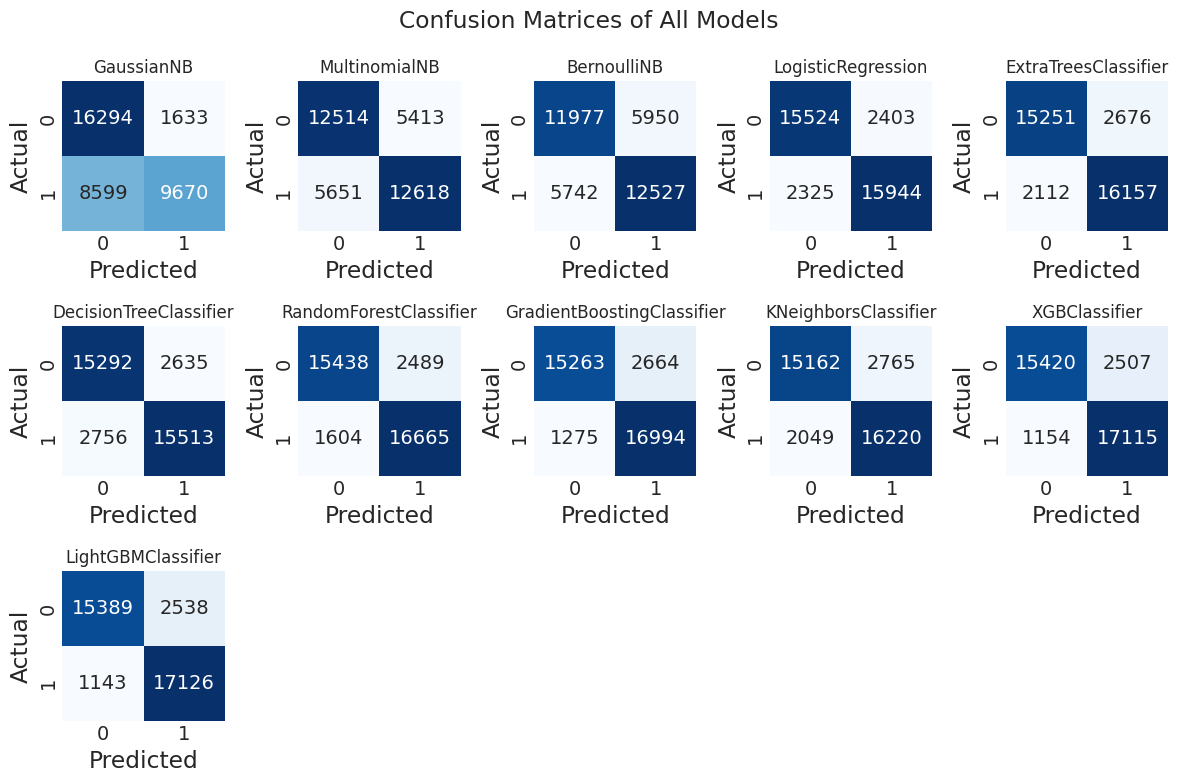

In [39]:
evaluate(x_train, y_train, x_test, y_test)

### Hyperparameter Tuning

In [50]:
grid_params = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [7, 10, 15],
    'learning_rate': [0.1, 0.05, 0.01],
}

In [47]:
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=grid_params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(x_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1], 'max_depth': [7, 10, ...], 'n_estimators': [300, 500, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [48]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

In [49]:
grid_search.best_score_

np.float64(0.8993921812405029)

## 6. Build Pipeline with the best model, Save the model, Make Submission

In [85]:
x = dfo[x.columns]
y = dfo['y']

In [86]:
preprocessor = ColumnTransformer([
    ('scaler', scaler, ['balance', 'duration']),
    ('onehot', OneHotEncoder(), ['job', 'marital', 'education', 'contact', 'month', 'poutcome']),
    ('ordinal', OrdinalEncoder(), ['housing'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(random_state=42, **grid_search.best_params_))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [87]:
y_pred = pipeline.predict(x)

In [88]:
confusion_matrix(y, y_pred)

array([[641705,  17807],
       [ 31022,  59466]])

In [89]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    659512
           1       0.77      0.66      0.71     90488

    accuracy                           0.93    750000
   macro avg       0.86      0.82      0.84    750000
weighted avg       0.93      0.93      0.93    750000



In [91]:
joblib.dump(pipeline, 'bank_classification_pipeline.pkl')

['bank_classification_pipeline.pkl']

In [92]:
test_df = pd.read_csv('test.csv', index_col='id')
predictions = pipeline.predict(test_df)
submission = pd.DataFrame({
    'id': test_df.index,
    'y': predictions
})
submission.head()

,id,y
0,750000,0
1,750001,0
2,750002,0
3,750003,0
4,750004,0


In [93]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
We built an end-to-end pipeline to predict the binary classification of the bank dataset. We used the `XGBClassifier` as the best model. We saved the pipeline for future use and used it to generate predictions for the test set.